<a href="https://colab.research.google.com/github/lzeng11bc/MLProjectsSKLearn/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3 Classification


## MNIST
***Featch the MNIST Dataset***

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

* **Datasets loaded by SK-Learn generally have a similar dictioanry strucutre including**
    * **A** DESCR **key describing the dataset**
    * **A** data **key contaiing an array with one row per instance and one column per feature**
    * **A** target **key containing an array with labels**

In [2]:
X, y = mnist["data"], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

**There are 70,000 images, and each image has 784 features.**
* **This is because each image is 28 x 28 pixels, and each feature simply represents one pixel's intensity, from 0(white) to 255(black).**

**Peek at one digit from the dataset**

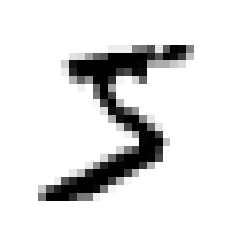

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

**Cast labels into numbers**

In [6]:
import numpy as np

y = y.astype(np.uint8)

**Train Test Split**

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
* **The “5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5.**
* **Let's create the target vectors for this classification task**

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Create a SGDClassifier and train it on the whole training set**

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Performance Measures

### Measuring Accuracy Using Cross-Validation
* **A good way to evalute a model is to use cross-validation**

##### Implementing Custom Cross-Validation

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


* **The** StratifiedKFold **class performs stratified sampling to produce folds that contain a representative ratio of each class**
* **At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test folds**

* **Let's use the** cross_val_socre( ) **function to evaluate your** SGDClassifier **model using K-fold cross-validation, with three folds**
* K-fold **cross-validation means splitting the training set into K-folds, then making predictions and evaluationg them on each fold using a model trained on the remaining folds.**

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, scoring="accuracy")

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

**Create a classifier that classifies every image in the "not-5" class**

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

**Find the model's accuracy**

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

* **This has demonstrated why accuracy is genrally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets***

### Confusion Matrix

* **A much better way to evaluate the performance of a classifier is to look at the *confusion matrix***
    * **The general idea is to count the number of times instances of class A are classified as class B.**
* **To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets.**

**Apply the** cross\_val\_predict( ) **function**

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

* **Just like the** cross\_val\_score( ) **function,** cross\_val\_predict( ) **performs K-fold cross-validation, but instead of returning the evluation scores, it returns the predictions made on each test fold**
* **This means that you get a clean prediction for each instance in the training set("clean" meaning that the prediction is made by a model that never saw the data during training)**

* **Get the confusion matrix**

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* **Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class***
    * **The first row of this matrix considers the negative class: true negatives and false positives**
    * **The second row considers positive class: flase negatives and true positives**
* **A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal**

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

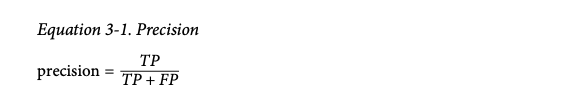

* **TP is the number of true positives, and FP is the number of false positives**

* **Precision is typically used along with another metric named *recall*, also called *sensitivity* or *true positive rate(TPR)*: this is the ratio of positive instances that are correctly detected by the classifier**

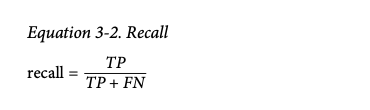

* **FN is the number of false negatives**

### Precision and Recall
* **SK-Learn provides several functions to compute classifier metrics, including precision and recall**

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

* **It is often convenient to combine precision and recall into a single metric called the $F_1$ score, particularyly if youy need a simple way to compare the two classifiers**
* **The $F_1$ score is the *harmonice mean* of precision and recall**
    * **The harmonic mean gives much more weight to low values.**

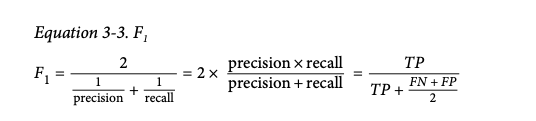

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**$F_1$ score favors classifiers that have similar precision and recall**

### Precision/Recall Tradeoff
* **SK-Lean does not let you set the threshold directly, but it does give you access to the decision scores taht it uses to make predictions.**
    * **Insted of calling the classifier's** predict( ) **method, you can call its** decision\_function( ) **method, which returns a score for each instances, and then make predictions based on those scores using any threshold you want**

In [20]:
y_scores = sgd_clf.decision_function([some_digit])

In [21]:
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

* **The** SGDClassifier **uses a threshold equal to 0, so the previous code returns the same result as the** predict( ) **method**
* **Now let's raise the threshold**

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

##### Decide which threshold to use?
* **You will first need to get the scores of all instances in the training set using the** cross\_val\_predict( ) **function, this time specifying that you want it to return decision scores instead of predictions**

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

**Compute the precision and recall for all possible thresholds using** precision\_recall\_curve( ) 

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

**Plot precision and recall as functions of the threshold value using Matplotlib**

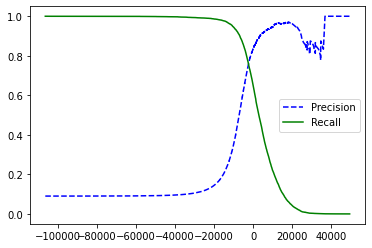

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

**Anotehr way to select a good precision/recall tradeoff is to plot precision directly against recall**

**Search for the lowest threshold that gives you at least 90% precision(** np.argmax( ) **will gve us the first index of the maximum value, which in this case means the first** True **value**

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)] 
threshold_90_precision

3370.0194991439557

**To make predictions, run the following code**

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

**Check the precision and recall**

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve
* **The *receiver operating characteristic*(ROC) curve is another common tool used with binary classifiers**
* **The ROC curve plots the *true positive rate* against the *false positive rate*.**

##### FPR 
* **The FPR is the ratios of negative instances that are incorretly classified as positive**
* **It is equal to one mins the *true negative rate*, which is the ratio of negative instances that are correctly classified as negative**
* **The TNR is also called *specificity*. Hence ROC curve plots *sensitivity*(recall) versus 1 - *specificity***

* **To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the** roc\_curve( ) **function**

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

**Then you can plot the FPR agains the TPR using Matplotlib**

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

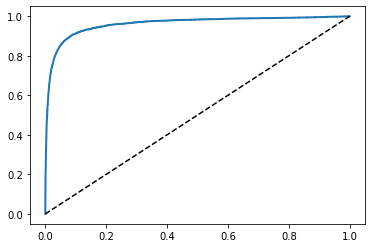

In [33]:
plot_roc_curve(fpr, tpr)
plt.show()

**The higher the recall(TPR), the more false positives(FPR) the classifier produces**
* **The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far wasy from that line as possible**

* **One way to compare the classifiers is to measure the *area under the curve***

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**You should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than false negatives, and the ROC curve otherwise**

**Train a** RandomForestClassifier **and compare its ROC curve and ROC AUC socre to the** SGDClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

* **we can use the positive class's probability as the score**

In [36]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

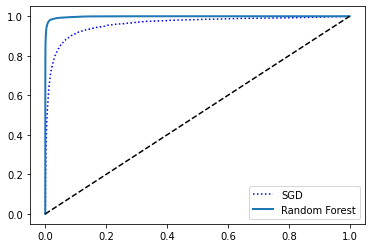

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

* **The** RandomForestClassifier **'s ROC curve looks much better than the** SGDClassifier's: **it comes closer to the top-left corner**
* **It's ROC AUC score is also significantly better**

### Multiclass Classification
* **One way to create a system that can classify the digit images into 10 classes(from 0 to 9) is to train 10 binary classifier.**
* **Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier otuputs the highest score. This is alled the *one-versus-all*(OvA) strategy(also called *one-versus-rest***